# Flood Insurance Damage Ratio Prediction Project

**Aim**: Use the redacted OpenFEMA dataset on flood insurance to predict the damage ratio on buildings which were subject to flood damage.

**Business Value**: By providing the characteristics of a given property as it pertains to flood risk, this model predicts the expected damage ratio (property damage: property value ratio)

**Machine Learning Model**: The best performing model was found to be a Random Forest model which outperformed XGBoost and Linear Regression models

Source website: https://www.fema.gov/openfema-data-page/fima-nfip-redacted-claims-v2

In [1]:
#import libraries here

import requests
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import shap
import joblib

C:\Users\rossi\anaconda3\envs\ibm_ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Acquisition and Initial Inspection

In [2]:
def fetch_fema_claims(state='FL', total_records=5000):
    base_url = "https://www.fema.gov/api/open/v2/FimaNfipClaims"

    # Define our filters: State is Florida
    # We use $filter for the state and $top for the limit per call (max 1000)
    # Damage Ratio target: We'll need buildingValueTotal and amountPaidOnBuildingClaim
    records_per_page = 1000
    all_data = []

    print(f"Starting data pull for {state}...")

    for skip in range(0, total_records, records_per_page):
        # Construct the API query
        query = (
            f"?$filter=state eq '{state}'"
            f"&$top={records_per_page}"
            f"&$skip={skip}"
        )

        response = requests.get(base_url + query)

        if response.status_code == 200:
            data = response.json().get('FimaNfipClaims', [])
            all_data.extend(data)
            print(f"Retrieved {len(all_data)} records...")
        else:
            print(f"Error: {response.status_code}")
            break

        # add a small sleep between calls
        time.sleep(0.5)

    return pd.DataFrame(all_data)

In [3]:
#Pull 5000 rows of data for Florida and assign to a dataframe
df_raw = fetch_fema_claims('FL', 5000)

Starting data pull for FL...
Retrieved 1000 records...
Retrieved 2000 records...
Retrieved 3000 records...
Retrieved 4000 records...
Retrieved 5000 records...


In [4]:
df_raw.describe()

,basementEnclosureCrawlspaceType,policyCount,crsClassificationCode,elevationDifference,baseFloodElevation,locationOfContents,lowestAdjacentGrade,lowestFloorElevation,numberOfFloorsInTheInsuredBuilding,obstructionType,...,floodWaterDuration,iccCoverage,netIccPaymentAmount,numberOfUnits,buildingReplacementCost,contentsReplacementCost,waterDepth,buildingDescriptionCode,latitude,longitude
count,1250.000000,5000.000000,326.000000,2169.000000,1960.000000,3284.000000,1586.000000,2000.000000,4990.000000,2309.000000,...,3425.000000,4079.000000,5000.000000,4996.000000,3.669000e+03,2218.000000,4564.000000,2045.000000,4965.000000,4965.000000
mean,0.268000,2.283800,6.423313,1.232365,62.867143,3.468027,-41.338020,23.220800,1.521643,17.156778,...,0.167883,28191.958813,85.948400,2.552642,2.162810e+06,5307.631199,3.407099,1.336919,27.419094,-82.131782
std,0.692647,12.386345,1.252177,4.365396,711.897901,1.002531,2536.667085,317.365841,0.889254,17.205799,...,2.765170,4387.180270,1525.249406,13.244775,4.459112e+07,27417.705015,15.069854,1.525206,1.666649,1.918501
min,0.000000,1.000000,4.000000,-12.000000,0.000000,2.000000,-99999.900000,-1.200000,1.000000,10.000000,...,0.000000,15000.000000,0.000000,0.000000,0.000000e+00,0.000000,-98.000000,1.000000,24.500000,-95.600000
25%,0.000000,1.000000,6.000000,0.000000,7.000000,3.000000,4.300000,7.400000,1.000000,10.000000,...,0.000000,30000.000000,0.000000,1.000000,4.783200e+04,0.000000,0.000000,1.000000,26.100000,-82.700000
50%,0.000000,1.000000,6.000000,1.000000,8.000000,3.000000,6.100000,9.300000,1.000000,10.000000,...,0.000000,30000.000000,0.000000,1.000000,1.651290e+05,0.000000,0.000000,1.000000,27.300000,-81.900000
75%,0.000000,1.000000,7.000000,2.000000,10.000000,4.000000,7.900000,12.700000,2.000000,10.000000,...,0.000000,30000.000000,0.000000,1.000000,3.158900e+05,0.000000,2.000000,1.000000,28.300000,-80.400000
max,4.000000,356.000000,10.000000,96.000000,9990.000000,7.000000,9998.300000,9997.000000,6.000000,98.000000,...,72.000000,30000.000000,30000.000000,356.000000,1.705240e+09,397500.000000,481.000000,13.000000,40.900000,-73.600000


In [5]:
df_raw.columns

Index(['agricultureStructureIndicator', 'asOfDate',
       'basementEnclosureCrawlspaceType', 'policyCount',
       'crsClassificationCode', 'dateOfLoss', 'elevatedBuildingIndicator',
       'elevationCertificateIndicator', 'elevationDifference',
       'baseFloodElevation', 'ratedFloodZone', 'houseWorship',
       'locationOfContents', 'lowestAdjacentGrade', 'lowestFloorElevation',
       'numberOfFloorsInTheInsuredBuilding', 'nonProfitIndicator',
       'obstructionType', 'occupancyType', 'originalConstructionDate',
       'originalNBDate', 'amountPaidOnBuildingClaim',
       'amountPaidOnContentsClaim',
       'amountPaidOnIncreasedCostOfComplianceClaim',
       'postFIRMConstructionIndicator', 'rateMethod',
       'smallBusinessIndicatorBuilding', 'totalBuildingInsuranceCoverage',
       'totalContentsInsuranceCoverage', 'yearOfLoss',
       'primaryResidenceIndicator', 'buildingDamageAmount',
       'buildingDeductibleCode', 'netBuildingPaymentAmount',
       'buildingPropertyValu

Our target variable, damage ratio, is equivalent to the amount paid on building claim column divided by the property value column. Before performing EDA, we will immediately drop all rows where either of these columns is missing. We will also drop all rows where the building property value is 0 since this will through up a divide by zero error.

In [6]:
df = df_raw.dropna(subset=['amountPaidOnBuildingClaim', 'buildingPropertyValue'])
df = df[df['buildingPropertyValue']!=0]
df['damage_ratio'] = df['amountPaidOnBuildingClaim']/df['buildingPropertyValue']
df = df[df['elevationDifference'] >= 0] #Only consider records with positive elevationDifference since the negative could represent a data entry error or being above flood elevation

#create the age of property column before pipeline to simplify post processing
df['age_of_property']=df['yearOfLoss'] - pd.to_datetime(df['originalConstructionDate'],  errors='coerce', format='mixed').dt.year

# 1. Identify unrealistic outliers (e.g., Ratio > 2.0)
data_mask = df['damage_ratio'] > 2.0
print(f"Dropping {data_mask.sum()} records with physically impossible ratios (> 200%)")
df = df[~data_mask].copy()

# 2. Clip the remaining "Total Losses" to 1.0
df['damage_ratio'] = df['damage_ratio'].clip(upper=1.0)



Dropping 0 records with physically impossible ratios (> 200%)


## Exploratory Data Analysis

C:\Users\rossi\AppData\Local\Temp\ipykernel_9912\3506987506.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=var, y='damage_ratio', ax=axes[i], order=order, palette='viridis')
C:\Users\rossi\AppData\Local\Temp\ipykernel_9912\3506987506.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=var, y='damage_ratio', ax=axes[i], order=order, palette='viridis')
C:\Users\rossi\AppData\Local\Temp\ipykernel_9912\3506987506.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=var, y='damage_ratio', ax=axes[i], order=

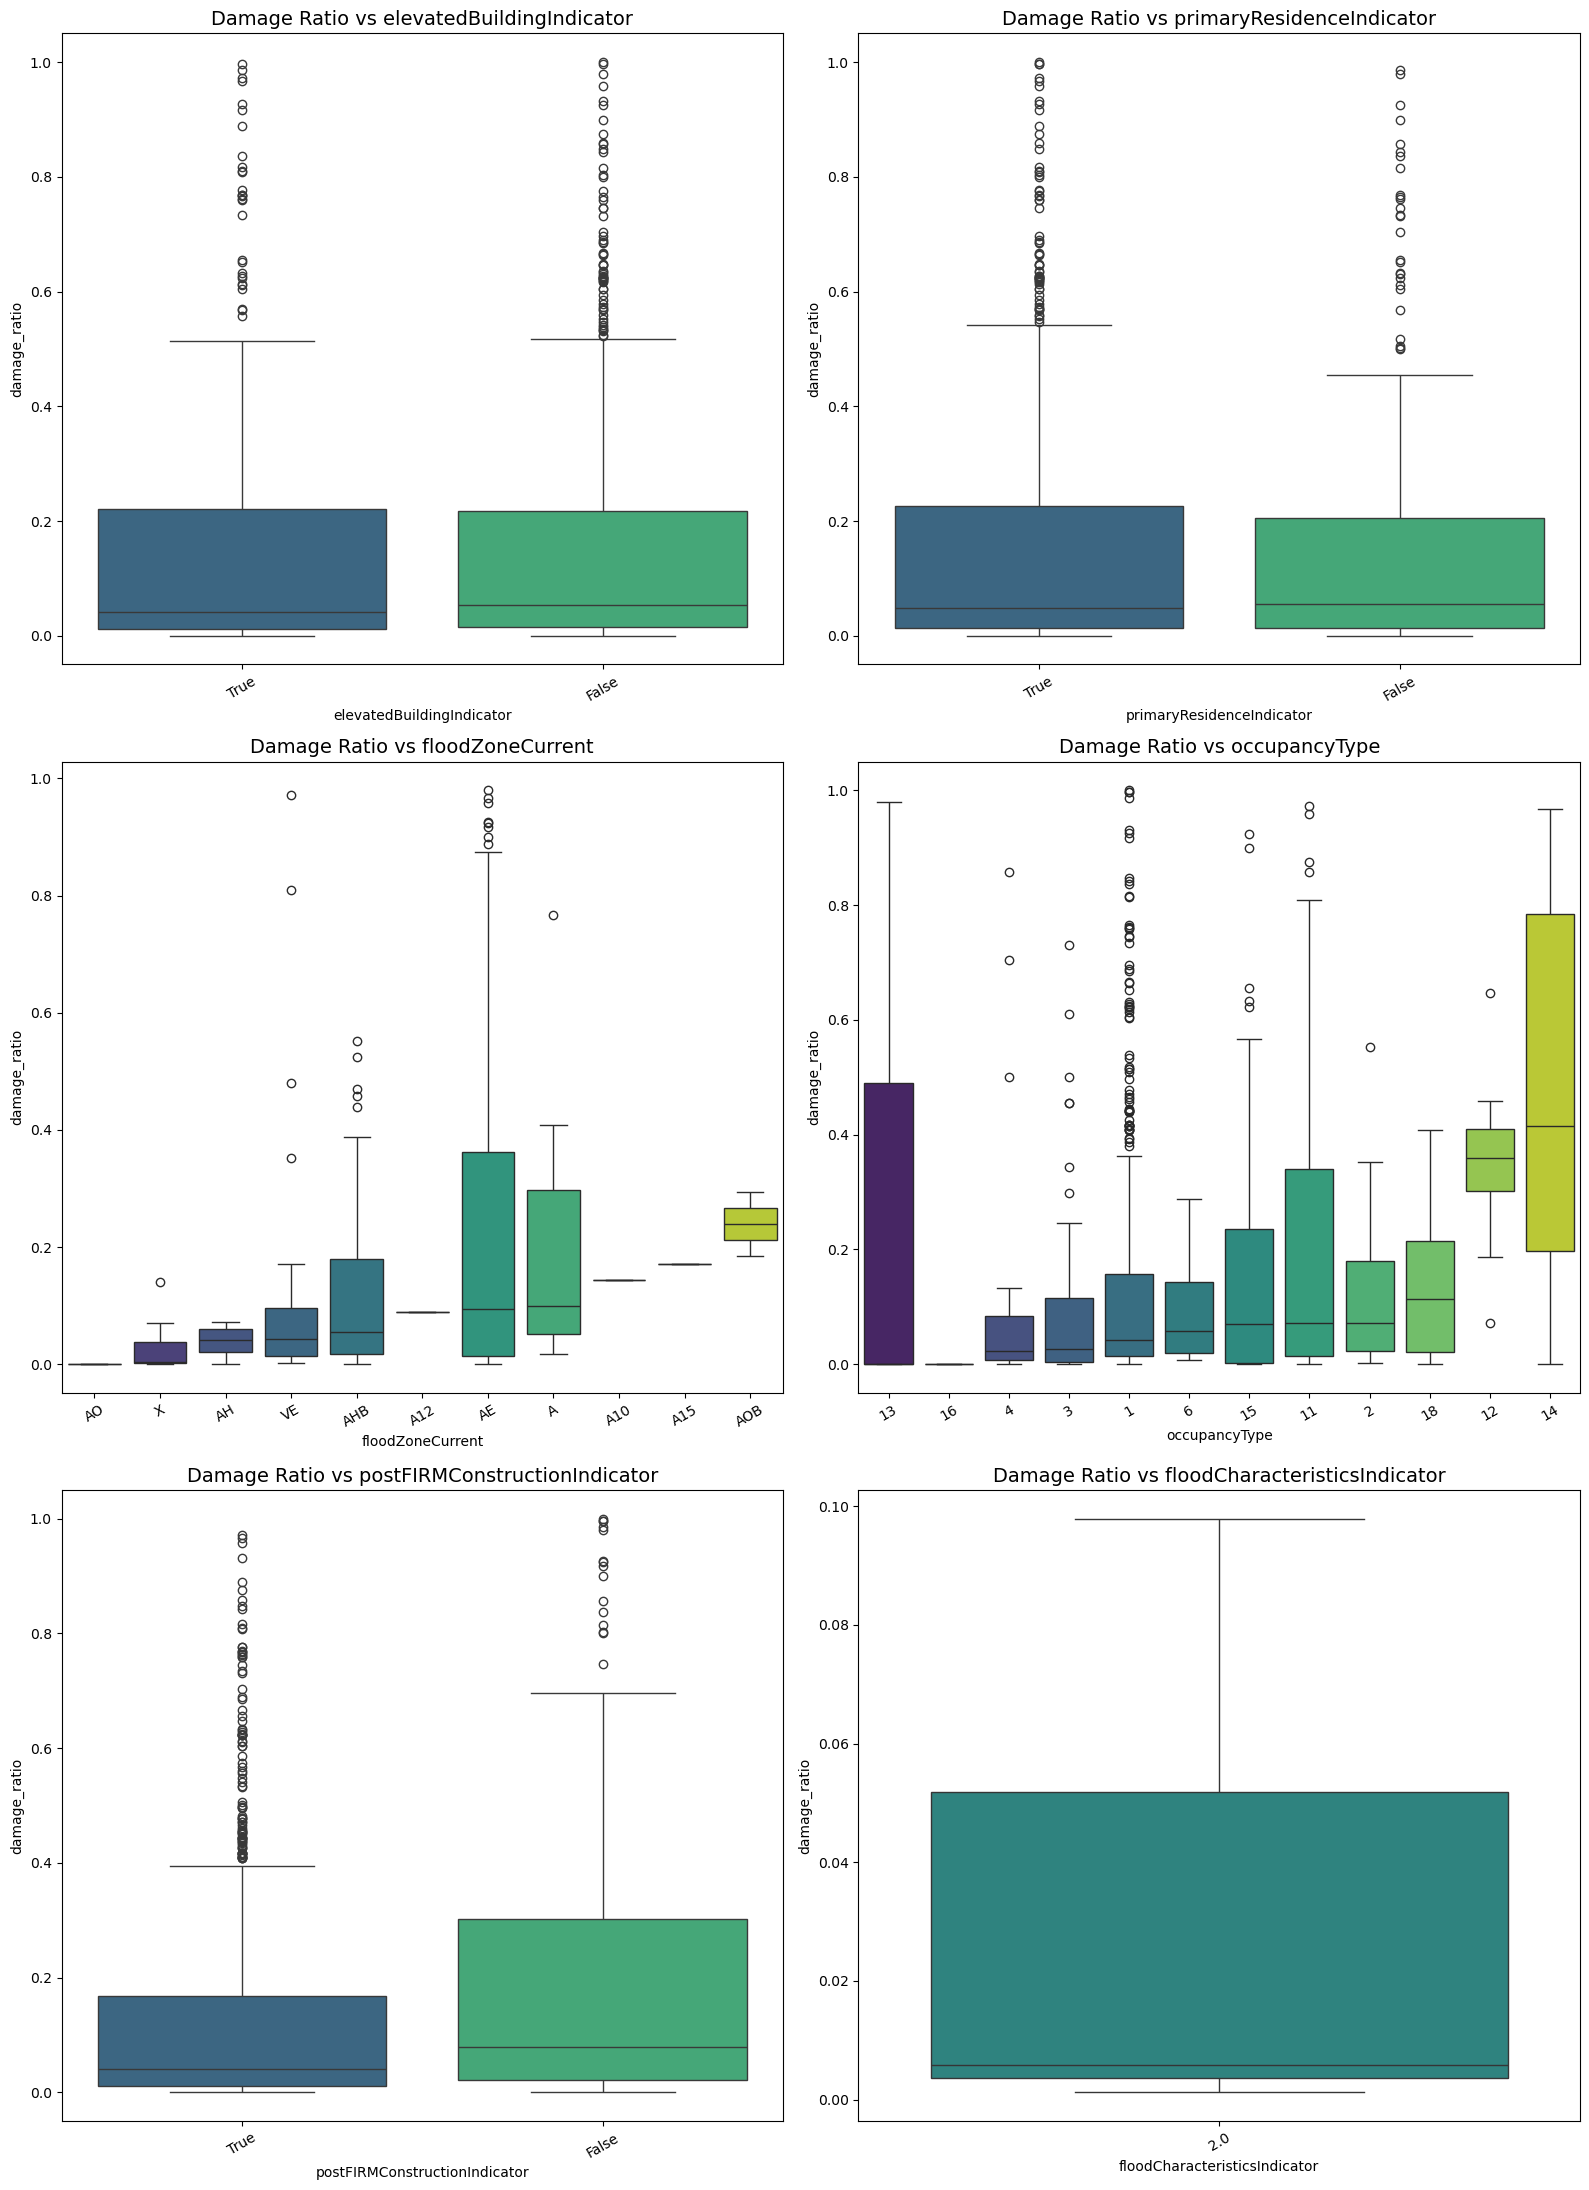

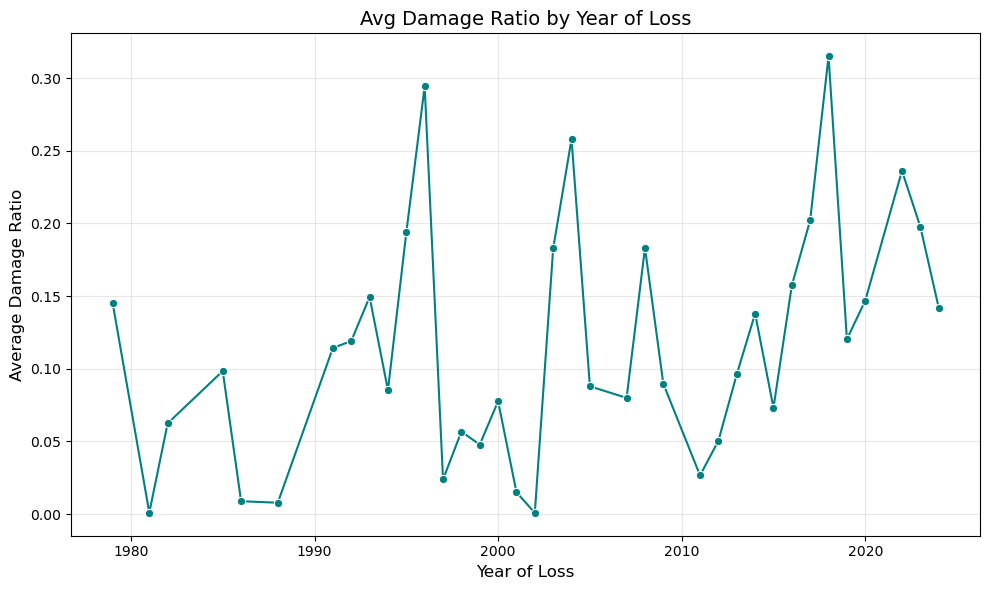

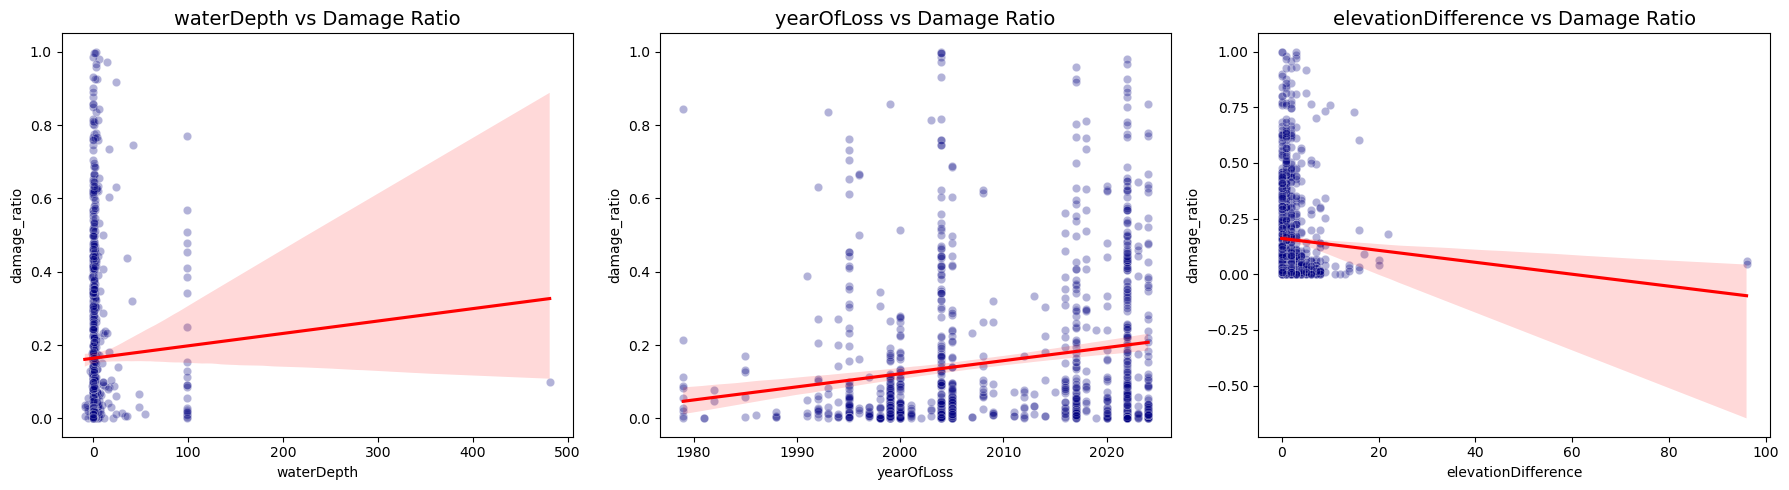

In [7]:
#Create a few plots to visualize the relationship between the target variable and some select features

# --- PLOT 1: Categorical Boxplots ---
cat_vars = ['elevatedBuildingIndicator','primaryResidenceIndicator', 'floodZoneCurrent',
            'occupancyType', 'postFIRMConstructionIndicator', 'floodCharacteristicsIndicator']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 22))
axes = axes.flatten()

for i, var in enumerate(cat_vars):
    # Sort by median for better visualization
    order = df.groupby(var)['damage_ratio'].median().sort_values().index
    sns.boxplot(data=df, x=var, y='damage_ratio', ax=axes[i], order=order, palette='viridis')
    axes[i].set_title(f'Damage Ratio vs {var}', fontsize=14)
    axes[i].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.savefig('categorical_boxplots.png')

# --- PLOT 2: Line Graph (Time Trend) ---

plt.figure(figsize=(10, 6))

df_loss = df.groupby('yearOfLoss')['damage_ratio'].mean().reset_index()
sns.lineplot(data=df_loss, x='yearOfLoss', y='damage_ratio', marker='o', color='teal')

plt.title('Avg Damage Ratio by Year of Loss', fontsize=14)
plt.xlabel('Year of Loss', fontsize=12)
plt.ylabel('Average Damage Ratio', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('time_trend.png')
plt.show()

# --- PLOT 3: Scatter Plots (Numerical Relationships) ---

num_vars = ['waterDepth', 'yearOfLoss', 'elevationDifference']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, var in enumerate(num_vars):
    sns.scatterplot(data=df, x=var, y='damage_ratio', alpha=0.3, ax=axes[i], color='navy')
    # Add a simple linear regression line to see the general direction
    sns.regplot(data=df, x=var, y='damage_ratio', scatter=False, ax=axes[i], color='red')
    axes[i].set_title(f'{var} vs Damage Ratio', fontsize=14)

plt.tight_layout()
plt.savefig('numerical_scatters.png')

C:\Users\rossi\AppData\Local\Temp\ipykernel_9912\597981799.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='floodZoneCurrent', y='damage_ratio',


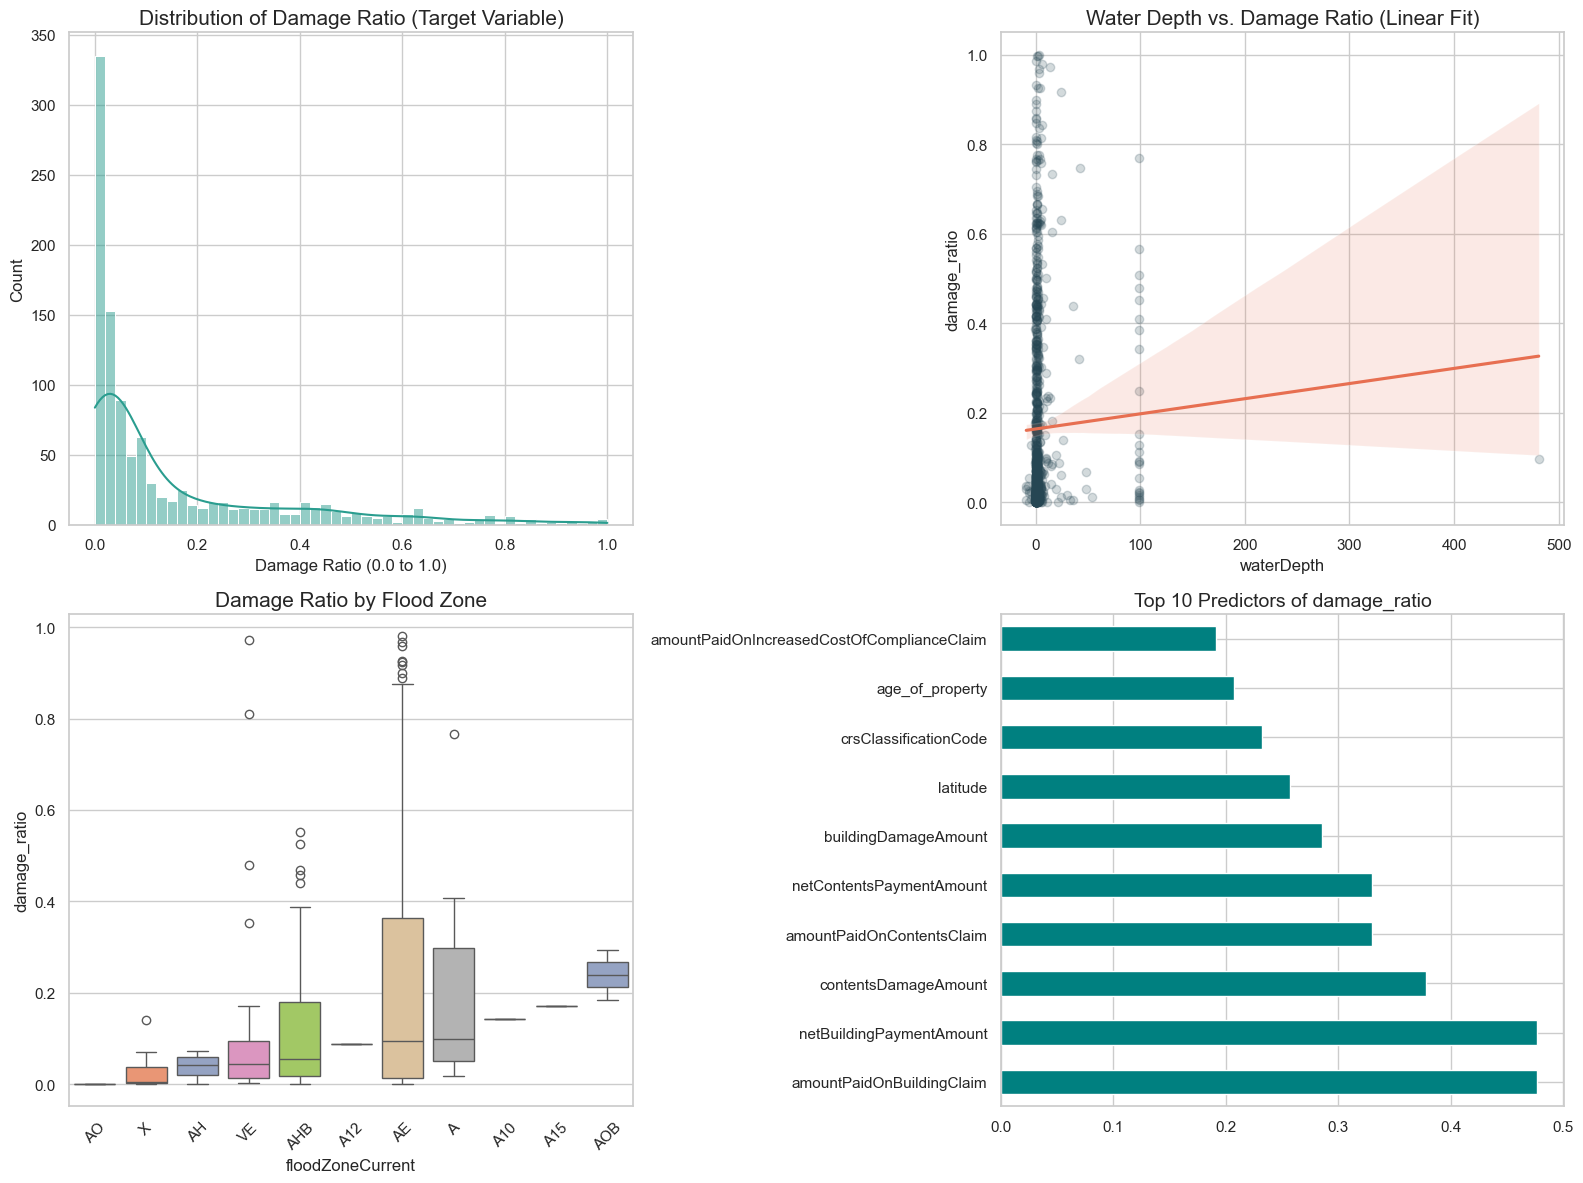

In [8]:
#Create some more detailed plots showing narrowing in on specific variables as follows

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Target Distribution
sns.histplot(df['damage_ratio'], bins=50, kde=True, ax=axes[0, 0], color='#2a9d8f')
axes[0, 0].set_title('Distribution of Damage Ratio (Target Variable)', fontsize=15)
axes[0, 0].set_xlabel('Damage Ratio (0.0 to 1.0)')

# Plot 2: Water Depth vs. Damage
sns.regplot(data=df, x='waterDepth', y='damage_ratio',
            scatter_kws={'alpha':0.2, 'color':'#264653'},
            line_kws={'color':'#e76f51'}, order=1, ax=axes[0, 1])
axes[0, 1].set_title('Water Depth vs. Damage Ratio (Linear Fit)', fontsize=15)

# Plot 3: Categorical Impact (The Grouped Flood Zones)
# Sorted by median for better readability
zone_order = df.groupby('floodZoneCurrent')['damage_ratio'].median().sort_values().index
sns.boxplot(data=df, x='floodZoneCurrent', y='damage_ratio',
            order=zone_order, palette='Set2', ax=axes[1, 0])
axes[1, 0].set_title('Damage Ratio by Flood Zone', fontsize=15)
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 4: Pearson Correlation Bargraph

target_var = 'damage_ratio'
target_corr = df.select_dtypes(include=[np.number]).corr()[target_var].sort_values(ascending=False)
target_corr = target_corr.drop(labels=[target_var])

target_corr.head(10).plot(kind='barh', color='teal')
axes[1, 1].set_title(f'Top 10 Predictors of {target_var}', fontsize=14)

plt.tight_layout()
plt.show()

## Data Cleaning and Feature Engineering

The damage claim parameter is dependent on the building value and the 'amount paid on building claim' parameters. Since these are the target values, determine if there are null values in the dataset and delete those rows

In [9]:
# Create a custom class to clean data and do feature engineering on the raw dataframe

class DataPrep(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Identify boolean columns and convert to int for analysis
        bool_cols = X.select_dtypes(include=['bool']).columns
        X[bool_cols] = X[bool_cols].astype(int)

        #Create a column for the age of the property at the flood event
       
        cols_to_keep = ['elevatedBuildingIndicator', 'waterDepth','occupancyType', 'age_of_property', 'yearOfLoss',
                        'elevationDifference', 'floodZoneCurrent', 'primaryResidenceIndicator',
                        'postFIRMConstructionIndicator'] #manually chosen variables of interest based on initial correlations and domain knowledge

        return X[cols_to_keep]

## Pipeline Building

In [10]:
# --- PIPELINE DEFINITION ---

# 1. Numerical data - decided to use median instead of mean to minimize impact of outliers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# 2. Categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 3. Automated selector combines the imputation
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, make_column_selector(dtype_include='number')),
        ('cat', categorical_transformer, make_column_selector(dtype_include=['object', 'category']))
    ],
    verbose_feature_names_out=True # Prefix names for clarity
)


### Model Selection Strategy: ##

I have intentionally excluded scaling from the global preprocessing pipeline. Tree-based models (Random Forest and XGBoost) are scale-invariant, and maintaining raw feature values aids in model interpretability. Scaling is applied exclusively to the Linear Regression candidate via a local pipeline to ensure coefficients are properly regularized."

In [11]:
# 3. Model training

X = df.drop('damage_ratio', axis=1)
y = df['damage_ratio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

prep_pipeline = Pipeline(steps=[
        ('feature_eng', DataPrep()),
        ('preprocessing', preprocessor),
        ])

X_train_transformed = prep_pipeline.fit_transform(X_train)

X_test_transformed = prep_pipeline.transform(X_test)



# 1. Create a dictionary of models to test
models = {
    "Linear Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    "Random Forest": RandomForestRegressor(n_estimators=150, max_depth=10, random_state=40),
    "XGBoost": XGBRegressor(n_estimators=150, learning_rate=0.05, max_depth=4, random_state=40, reg_alpha = 0.01)
  }

results = []

# 2. Loop through the dictionary
for name, model in models.items():
    
    # Fit the model and predict on training data
    model.fit(X_train_transformed, y_train)
    y_pred = model.predict(X_test_transformed)

    # Calculate Metrics
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE": mae,
        "R2 Score": r2
    })

# 3. Display as a clean DataFrame for comparison
results_df = pd.DataFrame(results).sort_values(by="MAE")
print(results_df)

               Model       MAE  R2 Score
1      Random Forest  0.138657  0.113805
2            XGBoost  0.141680  0.081909
0  Linear Regression  0.146549  0.073350


### Hyperparameter Tuning

In [12]:
# Use a GridSearchCV to tune the parameters of the best model - Random Forest in this case

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 15, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__max_features': ['sqrt', 'log2']
}

# Rerun the pipeline
best_model_pipe = Pipeline(steps=[
    ('prep', prep_pipeline),
    ('model', RandomForestRegressor(random_state=40))
])

# Setup GridSearchCV
# 5-fold cross-validation is chosen for this application
grid_search = GridSearchCV(
    estimator=best_model_pipe,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error', # MAE is chosen as criterion to better understand error
    n_jobs=-1,
    verbose=1
)

# Fit to the training data
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

# Extract results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV MAE: {-grid_search.best_score_:.4f}")

# Update your final model with the best parameters
final_model = grid_search.best_estimator_

Starting Grid Search...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_split': 5, 'model__n_estimators': 100}
Best CV MAE: 0.1434


In [13]:
# 1. Use the final model to predict on the unseen data
y_pred = final_model.predict(X_test)

# 2. Calculate the final r2 and MAE on the test set

final_r2 = r2_score(y_test, y_pred)
final_mae = mean_absolute_error(y_test, y_pred)

print(f"Final R2: {final_r2:.4f}")
print(f"Final MAE: {final_mae:.4f}")

Final R2: 0.1536
Final MAE: 0.1362


### Feature Importance

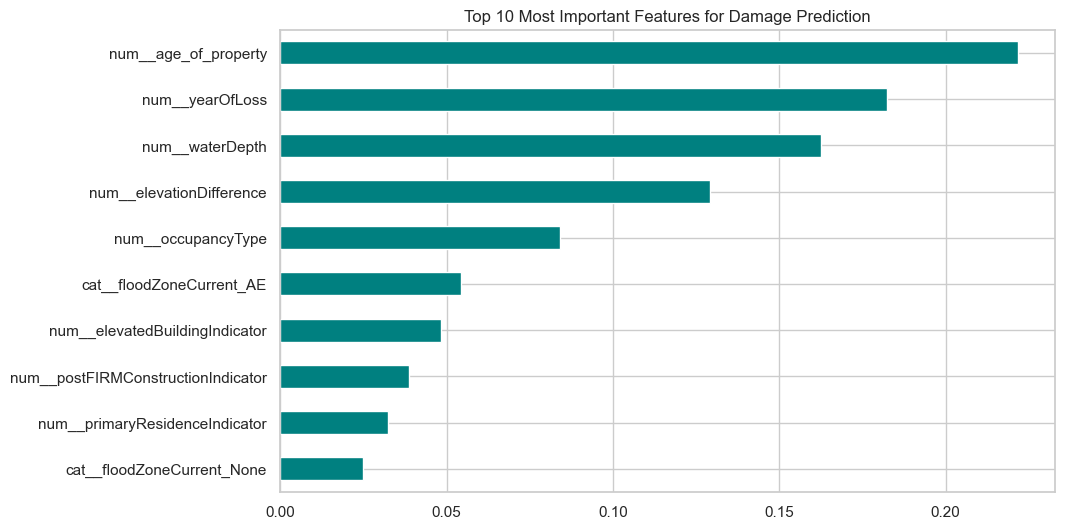

In [14]:
# Use the final model parameters to create a bar plot of feature importance

# Get all feature names
all_features = preprocessor.get_feature_names_out()

# Get importances from the model
importances = final_model.named_steps['model'].feature_importances_

# Create bar chart to display feature importances
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=True)
feat_imp.tail(10).plot(kind='barh', figsize=(10, 6), color='teal')
plt.title('Top 10 Most Important Features for Damage Prediction')
plt.show()

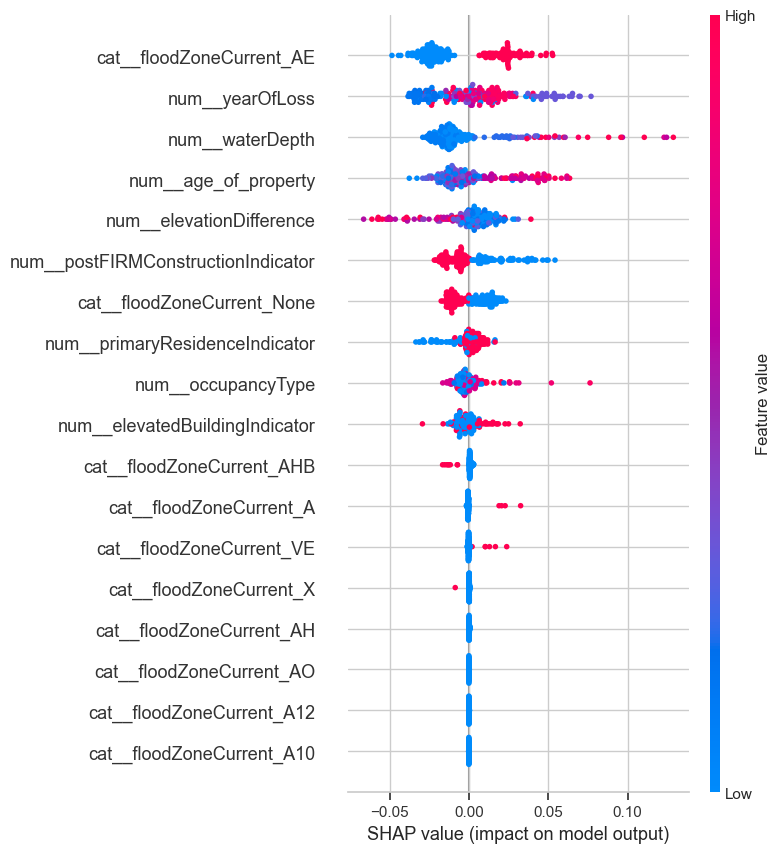

In [15]:
#SHapley Additive exPlanations (SHAP)

# Initialize the Explainer as part of SHAP analysis and run
explainer = shap.TreeExplainer(final_model.named_steps['model'])

shap_values = explainer.shap_values(X_test_transformed)

# Plot the valaues
shap.summary_plot(shap_values, X_test_transformed, feature_names=all_features)

### Model Interpretability & Key Drivers

The final Random Forest model identifies a few primary drivers of flood damage. These relationships were validated using SHAP (SHapley Additive exPlanations) to ensure the model's logic aligns with the physical and economic realities of flood risk:

Geospatial Risk (Flood Zone AE): The model successfully distinguishes high-risk zones. Properties located within Zone AE—the Special Flood Hazard Area—are associated with higher damage outcomes, while properties outside this zone (blue values on the left) consistently show reduced risk profiles.

Year of Loss: A positive trend was observed between the year of the loss and the resulting damage ratio. This suggests that more recent flood events result in higher relative payouts, which can be attributed to significant construction inflation and the rising cost of labor and building materials over time. There also was a period of time in the middle of our dataset where predictions of damage ratio were particularly high (purple region)

Physical Hazard (Water Depth): As expected, water depth remains a critical driver. The model correctly identifies a direct relationship where lower water depths (blue SHAP values on the left) lead to lower damage ratios, confirming that the model is grounded in the basic physics of flood events.

Building Vulnerability (Age of Property): The property age emerged as a strong predictor of damage severity. Older properties consistently show higher damage ratios (indicated by red SHAP values on the right), likely due to the lack of modern flood-resistant materials and building standards present in older construction eras.

Mitigation Efficacy (Post-FIRM Indicator): Properties constructed after a community joined the NFIP (Post-FIRM) show significantly lower damage ratios (red values on the left). This provides strong evidence that federal floodplain management and modern elevation requirements are successfully mitigating financial loss.

ElevationDifference: this parameter had a lot of missingness and was imputed with the median so it's hard to interpret this finding. In future, better data should be gathered as this is an important characteristic.

### Residual Plot Analysis

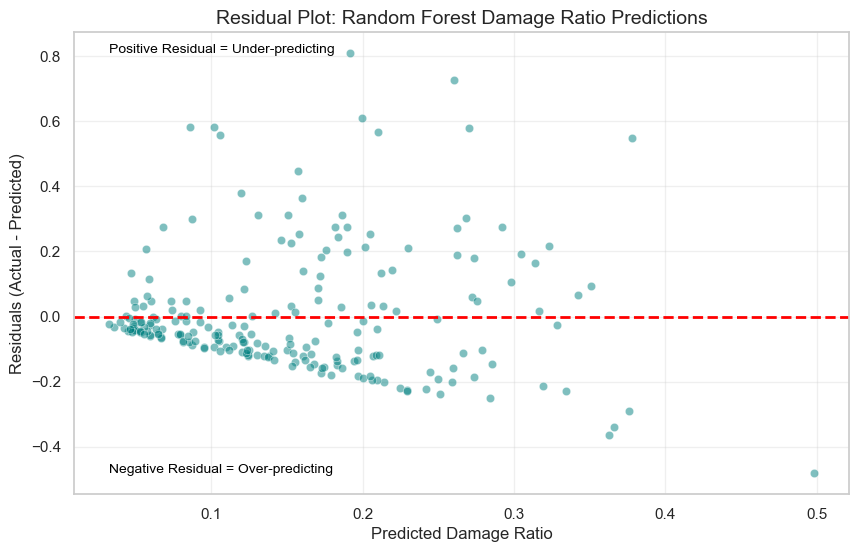

In [16]:
# Calculate the residuals by calculating the difference between the test and predicted y values
residuals = y_test - y_pred

# Plot residuals and format chart
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, color='teal')

plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

plt.title('Residual Plot: Random Forest Damage Ratio Predictions', fontsize=14)
plt.xlabel('Predicted Damage Ratio', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.grid(True, alpha=0.3)

plt.text(y_pred.min(), residuals.max(), 'Positive Residual = Under-predicting', color='black', fontsize=10)
plt.text(y_pred.min(), residuals.min(), 'Negative Residual = Over-predicting', color='black', fontsize=10)

plt.show()

Looking at the residual scatter plot vs damage ratio, the model is much better at predicting at low damage ratios and gets progressively worse as the damage ratio increases. This is likely because the vast majority of data points are at lower damage ratios, as evidenced by the damage ratio histogram.

The overpredictions are generally more severe than the underpredictions which suggests that the predictions would be on the conservative side with respect to the expected damage ratio. However, perhaps the inclusion of additional features would help tighten up the predictions and reduce residuals.

## Data Limitations & Structural Constraints

While the model provides strong directional insights, the predictive power is currently constrained by significant data gaps inherent in public NFIP records:

Elevation Data Sparsity: Approximately 60% of the elevation data was missing. While this was handled using median imputation, the lack of precise elevation for the majority of the dataset limits the model's ability to assess its impact.

Missing Structural Attributes: The public dataset lacks critical "Vulnerability" variables such as Square Footage, Number of Stories, and Construction Material (e.g., Frame vs. Masonry). Without knowing the vertical distribution of value or the water-resistance of the walls, the model must rely on "Age of Property" as a proxy for these features.

Hydrodynamic Factors: Flood damage is not just driven by depth, but also by velocity and duration. Public claims data typically records the peak depth but lacks the "force" of the water (surge velocity), which is often the difference between a repairable home and a total structural failure.

## Strategies for Improving Model Performance ($R^2$)

To push the $R^2$ beyond the current ceiling, the following advanced data science strategies could be implemented:

Hurdle (Two-Stage) Modeling: Instead of a single regressor, implement a two-stage approach. First, train a Classifier to predict the probability of any damage (0 vs. >0). Then, for the predicted "Damage" rows, train a Regressor to estimate the severity. This addresses the "Zero-Inflation" bias that currently pulls the regression line toward the floor.

External Data Enrichment: Join the FEMA dataset with property-level data (e.g., Zillow or County Assessor records) to pull in Square Footage and Market Value. This would allow for a more accurate denominator when calculating the damage_ratio.

Add variables for predictive power: Consider including more data from the original dataset such as Flood characteristics which may be better predictors.

Spatial Encodings: Instead of just using "Flood Zone," incorporate Latitude and Longitude or H3 Hexagon bins. This allows the model to learn localized risks (e.g., specific neighborhoods with poor drainage) that a broad "Zone AE" label cannot capture.

### Build Streamlit App for Production

In [17]:
raw_features = [
    'elevatedBuildingIndicator', 'waterDepth', 'occupancyType', 
    'age_of_property', 'yearOfLoss', 'elevationDifference', 
    'floodZoneCurrent', 'primaryResidenceIndicator', 'postFIRMConstructionIndicator'
]

# 1. Get medians for all numeric columns (age, waterDepth, etc.)
raw_defaults = X_train[raw_features].median(numeric_only=True).to_dict()

# 2. Add categorical defaults
raw_defaults['floodZoneCurrent'] = X_train['floodZoneCurrent'].mode()[0]
raw_defaults['occupancyType'] = X_train['occupancyType'].mode()[0]

# 3. Store all possible Flood Zone options for the dropdown
flood_zone_options = [
    'A', 'A10', 'A12', 'AE', 'AH', 'AHB', 'AO', 'VE', 'X', 'None'
]

metadata = {
    'required_raw_features': raw_features,
    'defaults': raw_defaults,
    'flood_zones': flood_zone_options
}

joblib.dump(final_model, 'flood_model_v1.pkl')
joblib.dump(metadata, 'model_metadata.pkl')

['model_metadata.pkl']